<a href="https://colab.research.google.com/github/Victor0vich/Denis/blob/main/genomic_workshop_ml_in_bioinf_2024_partial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are a lot of different official torch geometric tutorials [here](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html). You can also use other libraries from writing GNNs (Tensorflow, DGL, etc.)



# Installation

In [9]:
! pip install torch_geometric

# Importing

In [10]:
import torch
import pickle
import numpy as np
from numpy import inf
import networkx as nx
import torch_geometric
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.nn import SAGEConv, GCNConv, LabelPropagation

# Example

Create some simple graph

In [11]:
# initialize empty graph
G = nx.Graph()

# add nodes and node features
G.add_nodes_from([
      (1, {'x': [0.1, 0.2, 0.3, 0.4, 0.5]}),
      (2, {'x': [0.1, 0.2, 0.3, 0.4, 0.5]}),
      (3, {'x': [0.6, 0.7, 0.8, 0.9, 1.0]}),
      (4, {'x': [1.1, 1.2, 1.3, 1.4, 1.5]}),
])

# add edges
G.add_edges_from([(1, 3), (2, 3)])

Visualize this simple graph

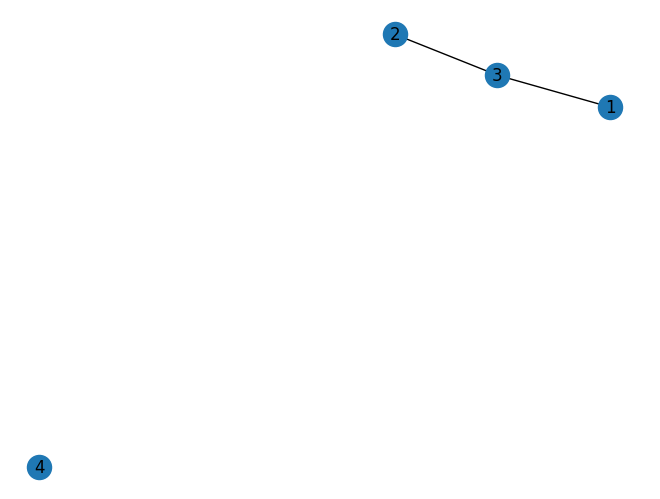

In [12]:
nx.draw(G, with_labels=True)

Convert `nx.Graph` to torch geometric `Data` object automatically

In [13]:
pyg_graph = from_networkx(G)
pyg_graph

Data(x=[4, 5], edge_index=[2, 4])

In [14]:
# here is the usful feature of Data object
pyg_graph.num_features

5

Note that now edges are duplicated. Why?

In [15]:
# directed graph?
pyg_graph.edge_index

tensor([[0, 1, 2, 2],
        [2, 2, 0, 1]])

Let's see how basic GCN layer works

In [16]:
hidden_dim = 5

In [18]:
gcn_layer = GCNConv(pyg_graph.num_features, hidden_dim, bias=False)

Let's see what is inside this layer

In [20]:
for name, param in gcn_layer.named_parameters():
    print(name, param.data)

lin.weight tensor([[-0.3473, -0.3518,  0.2330, -0.5072, -0.0569],
        [-0.6658, -0.1745, -0.7270,  0.5052, -0.2108],
        [ 0.5743,  0.4663, -0.5879, -0.0291, -0.5562],
        [ 0.2245, -0.4141,  0.3281, -0.2421,  0.2847],
        [-0.2893, -0.0863, -0.0977,  0.6547, -0.2502]])


We can see that parameters were randomly initialized. We will change them for simplicity

In [21]:
with torch.no_grad():
    gcn_layer.lin.weight = torch.nn.Parameter(torch.ones_like(gcn_layer.lin.weight))

In [22]:
for name, param in gcn_layer.named_parameters():
    print(name, param.data)

lin.weight tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


Now, let's see how features of our nodes in our graph will change when we pass our graph through GCN layer

In [23]:
with torch.no_grad():
    x = gcn_layer(pyg_graph.x, pyg_graph.edge_index)

In [24]:
x

tensor([[2.3830, 2.3830, 2.3830, 2.3830, 2.3830],
        [2.3830, 2.3830, 2.3830, 2.3830, 2.3830],
        [2.5581, 2.5581, 2.5581, 2.5581, 2.5581],
        [6.5000, 6.5000, 6.5000, 6.5000, 6.5000]])

How did we get this output? Have a look at the formula from [documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv).

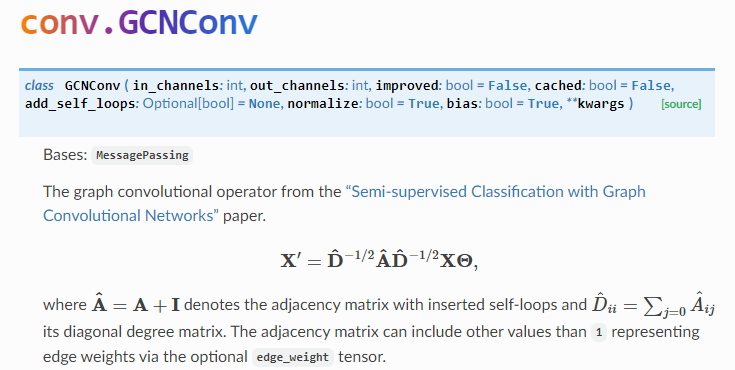

Let's write this formula from scratch. See the similarities with Symmetrically normalized Laplacian [here](https://en.wikipedia.org/wiki/Laplacian_matrix), just without self-loops

In [25]:
def manual_gcn(G, X):
    A = nx.adjacency_matrix(G).todense()
    A_hat = A + np.identity(A.shape[0])
    D_hat = nx.laplacian_matrix(G) + A + np.identity(A.shape[0]) # The graph Laplacian is the matrix L = D - A, where A is the adjacency matrix and D is the diagonal matrix of node degrees
    TETA = np.ones((pyg_graph.num_features, hidden_dim)) # like our layer weights
    with np.errstate(divide="ignore"):
        D_hat_pow = D_hat ** -0.5 # element-wise
    D_hat_pow[D_hat_pow == inf] = 0
    return D_hat_pow @ A_hat @ D_hat_pow, D_hat_pow @ A_hat @ D_hat_pow @ X @ TETA

In [27]:
norm_laplac, layer_output = manual_gcn(G, pyg_graph.x.numpy())

In [28]:
layer_output # same output as from torch geometric layer

array([[2.38299317, 2.38299317, 2.38299317, 2.38299317, 2.38299317],
       [2.38299317, 2.38299317, 2.38299317, 2.38299317, 2.38299317],
       [2.55807822, 2.55807822, 2.55807822, 2.55807822, 2.55807822],
       [6.5       , 6.5       , 6.5       , 6.5       , 6.5       ]])

Let's look a little bit in detail

In [29]:
# norm_laplac @ X @ TETA - below is first multiplier
norm_laplac

array([[0.5       , 0.        , 0.40824829, 0.        ],
       [0.        , 0.5       , 0.40824829, 0.        ],
       [0.40824829, 0.40824829, 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

In [30]:
# norm_laplac @ X @ TETA - below is second multiplier
pyg_graph.x.numpy()

array([[0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.6, 0.7, 0.8, 0.9, 1. ],
       [1.1, 1.2, 1.3, 1.4, 1.5]], dtype=float32)

We can notice that when we multiply `norm_laplac` by `X` we aggregate features only from local neighbors

Testing permutation equivariance. Let's create the same graph with the same features but different node labeling

In [31]:
G_new = nx.Graph()
G_new.add_nodes_from([
      (1, {'x': [1.1, 1.2, 1.3, 1.4, 1.5]}),
      (2, {'x': [0.6, 0.7, 0.8, 0.9, 1.0]}),
      (3, {'x': [0.1, 0.2, 0.3, 0.4, 0.5]}),
      (4, {'x': [0.1, 0.2, 0.3, 0.4, 0.5]}),
])
G_new.add_edges_from([(4, 2), (3, 2)])

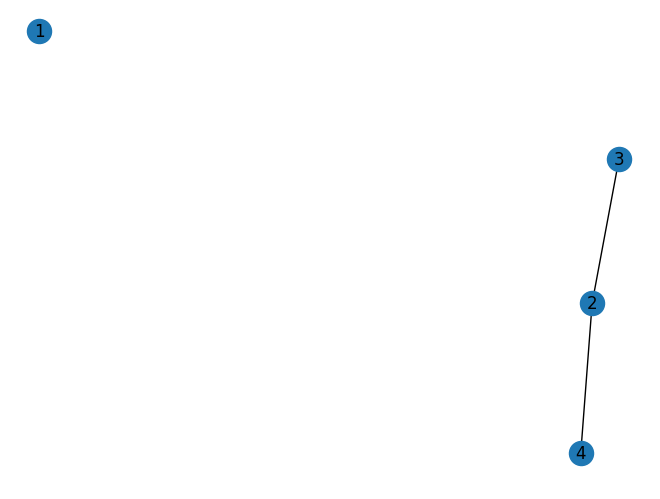

In [32]:
nx.draw(G_new, with_labels=True)

In [33]:
pyg_graph_new = from_networkx(G_new)

Let's check adjacency matrix from old and new graphs

In [34]:
# old
nx.adjacency_matrix(G).todense()

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 0]])

In [35]:
# new
nx.adjacency_matrix(G_new).todense()

array([[0, 0, 0, 0],
       [0, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

The order of features changed as well

In [36]:
pyg_graph.x

tensor([[0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.6000, 0.7000, 0.8000, 0.9000, 1.0000],
        [1.1000, 1.2000, 1.3000, 1.4000, 1.5000]])

In [37]:
pyg_graph_new.x

tensor([[1.1000, 1.2000, 1.3000, 1.4000, 1.5000],
        [0.6000, 0.7000, 0.8000, 0.9000, 1.0000],
        [0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.1000, 0.2000, 0.3000, 0.4000, 0.5000]])

Get output from GCN layer

In [38]:
with torch.no_grad():
    x_new = gcn_layer(pyg_graph_new.x, pyg_graph_new.edge_index)

In [39]:
x_new

tensor([[6.5000, 6.5000, 6.5000, 6.5000, 6.5000],
        [2.5581, 2.5581, 2.5581, 2.5581, 2.5581],
        [2.3830, 2.3830, 2.3830, 2.3830, 2.3830],
        [2.3830, 2.3830, 2.3830, 2.3830, 2.3830]])

Are CNN equvariant? What about MLP and Transformers (before and after positional encoding)?

# Exercise

Imagine you are the CEO of the company that sells genetic tests. Now you want to improve the accuracy of your DNA ancestry tests by using GNNs. How can we do that? You have the database that consists of a huge amount of SNPs after using microarray genotyping for each person. You decide to shrink all that data down by utilizing HMM that identifies common IBD regions between each pair of individuals, you calculate the total length of all common IBD segments between each pair of individuals in your database and construct IBD graph where edge between two individuals exists only if the length of all common IBD segments bigger than some threshold. Now you have such an IBD graph for your whole database. In order to train your NN correctly you need at least training and validation datasets. However, you need to mimic the situation when a new customer arrives and you need to calculate edges between the new client and your database for them each. Thus, you decide to split all your vertices in two parts: those that are designated for training (train nodes) and those that are for validation (valid nodes). Then you construct graph for training as a subgraph of initial graph with train nodes but for each valid node you construct its own graph as subgraph of initial graph with train nodes **+1 valid node**. For simplicity you can calculate features for each node directly from the graph: number of edges from current node to the neighbors per class (population group), mean edge weight of edges from current node to the neighbors per class, std of edge weights per class etc. Finally, you need to predict the population group for a group of new clients.

We already prepared the data for you, you just need to train your GNN properly. Follow the instructions below.



Mount Google Drive to Colab in order to access files for training your GNN. Move [this](https://drive.google.com/drive/folders/1iYfunzsIG3XYfxN1l2-ozGw7zvfu56jo?usp=sharing) files to you own Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Load files:

*   `train_graphs` - array of graphs for training GNN (actually, it's one graph)
*   `valid_graphs` - you will validate your model on these graphs during training
*   `unknown_graphs` - you need to predict labels for specific nodes in these graphs - **that will be you final answer**



In [ ]:
YOUR_PATH = #

with open(f'{YOUR_PATH}/train_graphs.pickle', 'rb') as handle:
    train_graphs = pickle.load(handle)

with open(f'{YOUR_PATH}/valid_graphs.pickle', 'rb') as handle:
    valid_graphs = pickle.load(handle)

with open(f'{YOUR_PATH}/unknown_graphs.pickle', 'rb') as handle:
    unknown_graphs = pickle.load(handle)

Examine data

In [ ]:
print(f'We have {len(train_graphs)} graph for training, {len(valid_graphs)} graph for validation and {len(unknown_graphs)} graphs where we need to predict label for vertex with unknown population group.')

Check the structure of those arrays of graphs. Note that graphs for validation and unknown graphs have just one vertex more than training graph, that's the requerements of our task. The number of edges has no any limits and may vary. Remember that we simulate behaviour of real company: we have our database (`train_graphs` which is actually array with one graph, we will use this graph to train our model, and `valid_graphs` which are train graph with one more different node added each, we know labels for all nodes in each graph in `valid_graphs` but we want to compute quality metrics only for those newly added nodes in order to mimic new customers that came to our company), than we train our GNN on `train_graphs` and validate on `valid_graphs`, after finding the model that gave us best scores on `valid_graphs`, we use that model to predict labels for unknown nodes in `unknown_graphs` - the last thing is the end of the task. For graphs in `unknown_graphs` we know labels for all nodes except one (this is your target node), the class of this node has been marked as `-1`, this is the last node in each graph. Here is the explanation of parameters in `Data` object:

*   `x` - features of each node (row `0` in `x` has features for node `0`, row `1` in `x` has features for node `1` etc.), those features were calculated based on the same graph because IBD graphs don't have node features
*   `edge_index` - edges between nodes (already duplicated)
*   `y` - labels (population groups) of each node, ordered the same as features in `x`
*   `weight` - edge weights, have the same ordering as `x` (may be helpful in some cases)
*   `mask` - in our task it's always boolean array where all values are True, however, you can modify it, hide some nodes during loss computation phase and see how it affects  performance
*   `num_classes` - int, total amount of unique labels







In [ ]:
train_graphs

Let's look at the class balance in training data

In [ ]:
population_groups, counts = np.unique(train_graphs[0].y.numpy(), return_counts=True)
print(f'Here is our population groups: {population_groups}')
print(f'Here is amount of vertices per each population group respectively: {counts}')

In [ ]:
valid_graphs

In [ ]:
unknown_graphs

We can treat `Data` object as a dictionary, you can fing more information about that class in [manual](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html). Here is how to access

In [ ]:
# this is your trainign graph
train_graphs[0]

In [ ]:
# this is your features
train_graphs[0].x

In [ ]:
train_graphs[0].x.shape

In [ ]:
# this is your edges between vertices
train_graphs[0].edge_index

In [ ]:
train_graphs[0].edge_index.shape

In [ ]:
# here is total number of population groups (labels)
train_graphs[0].num_classes

or add/remove parameters there

In [ ]:
# add new attribute
train_graphs[0].useless_parameter = 123

In [ ]:
# check that new attribute has been added correctly
train_graphs[0]

In [ ]:
# remove that new attrubute
train_graphs[0].useless_parameter = None

In [ ]:
# check that new attribute has been removed correctly
train_graphs[0]

Check that core of all graphs is the same. We need to convert `Data` object from Torch Geometric to `nx.Graph` object because only `networkx` library has the function to check graph isomorphism. [Here](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/convert.html) are some useful Torch Geometric utils (including `to_networkx` function, that has a lot of interesting parameters)

In [ ]:
train_graph_nx = to_networkx(train_graphs[0])

In [ ]:
print(f'Diameter of the training graph is: {nx.diameter(train_graph_nx)}')

In [ ]:
print(f'Is directed: {train_graph_nx.is_directed()}, number of edges: {train_graph_nx.number_of_edges()}, number of nodes: {train_graph_nx.number_of_nodes()}')

In [ ]:
train_graph_nx = nx.Graph(train_graph_nx)

In [ ]:
print(f'Is directed: {train_graph_nx.is_directed()}, number of edges: {train_graph_nx.number_of_edges()}, number of nodes: {train_graph_nx.number_of_nodes()}')

In [ ]:
# this may run up to 15 min long, it is not necessary for the task, you can skip it
for graph in valid_graphs:
    nx_graph = nx.Graph(to_networkx(graph))
    nx_graph = nx_graph.subgraph([i for i in range(train_graph_nx.number_of_nodes())])
    assert nx.vf2pp_is_isomorphic(nx_graph, train_graph_nx, node_label=None)

In [ ]:
# this may run up to 5 min long, it is not necessary for the task, you can skip it
for graph in unknown_graphs:
    nx_graph = nx.Graph(to_networkx(graph))
    nx_graph = nx_graph.subgraph([i for i in range(train_graph_nx.number_of_nodes())])
    assert nx.vf2pp_is_isomorphic(nx_graph, train_graph_nx, node_label=None)

Define GNN model. Hints: use `SAGEConv` layers and `ELU` activation function, don't use large hidden size, `128` is upper limit. Also, `Data(...).num_features` will give you 2-nd dimention of you features which is useful for stacking layers. You can convert your torch tensors to float dtype by using `.float()`. [Here](https://pytorch-geometric.readthedocs.io/en/latest/cheatsheet/gnn_cheatsheet.html) is the list of all layers available in torch geometric.

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, data):
        super(Model, self).__init__()
        self.conv1 = # SAGEConv
        # ...

    def forward(self, data):
        # x, edge_index = ...
        # ...

        return x

Initialize model, loss and optimizer. Remember, we solve single-label classification problem

In [ ]:
model = # ...
criterion = # ...
optimizer = # ...

Validation function

In [ ]:
def validate(model, val_graphs):
    # ... (remember to validate only on newly added nodes, do not use all 1110 nodes for validation)

    return # f1 macro score

Training loop

In [ ]:
# drop gradients
# predict
# validate
# calculate loss
# backpropagation
# change optimizer state

Testing on unknown nodes

In [ ]:
# model.eval()
# ...

Visualize predictions. The node that is bigger than others is your target node.

In [ ]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def visualize_predictions(model, test_graph, number_of_classes, use_component=False):
    '''
    Function that helps visually compare predictions from the model with grounnd truth values

    Parameters
    model: your trained model
    test_graph: Data(...) object from torch geometric
    number_of_classes: num_classes in Data(...) object
    use_component: if True, will draw the whole component with target node, otherwise (if False) will draw only target node and neighbors of target node
    '''
    preds = np.argmax(F.softmax(model(test_graph), dim=1).cpu().detach().numpy(), axis=-1)

    graph = to_networkx(test_graph, edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)
    print(f'Number of initial nodes: {len(graph)}')
    last_node_id = len(graph)-1
    pred_attrs = {i:{'predict':p} for i, p in enumerate(preds)}
    nx.set_node_attributes(graph, pred_attrs)

    if use_component:
        print(f'Number of connected components:{nx.number_connected_components(graph)}')
        for c in nx.connected_components(graph):
            if len(graph)-1 in c:
                test_node_neighbors = list(c)
                break
    else:
        test_node_neighbors = list(graph.neighbors(len(graph)-1)) + [len(graph)-1]

    graph = nx.subgraph(graph, test_node_neighbors)
    print(f'Number of final nodes: {len(graph)}')
    node_classes = [f'P{i}' for i in range(number_of_classes)]
    if -1 in test_graph.y:
        node_classes.append('unknown')

    cmap = mpl.colormaps['jet']
    px = 1 / plt.rcParams['figure.dpi']
    colors = cmap(np.linspace(0, 1, len(np.unique(node_classes))))

    pos = nx.spring_layout(graph, iterations=10)
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1400 * px, 600 * px))
    ax1.axis('off')
    ax2.axis('off')
    ax2.set_title(f'Ground truth')
    ax1.set_title(f'Prediction')

    y = list(nx.get_node_attributes(graph,'y').values())
    mask = np.array(list(nx.get_node_attributes(graph,'mask').values()))
    preds = list(nx.get_node_attributes(graph,'predict').values())

    current_node_colors = []
    real_node_colors = []

    for cls in y:
        real_node_colors.append(colors[cls])

    for cls in preds:
        current_node_colors.append(colors[cls])

    if np.sum(~mask) == 0:
        nx.draw_networkx_nodes(graph, pos=pos, node_color=current_node_colors, node_size=[24 if node != last_node_id else 150 for node in graph.nodes], ax=ax1)
    else:
        print('Using masks')
        assert np.all(np.array(list(graph)) == np.array(list(graph.nodes)))
        nx.draw_networkx_nodes(graph, pos=pos, nodelist=np.array(list(graph))[mask], node_color=np.array(current_node_colors)[mask], node_size=[24 if node != last_node_id else 150 for node in np.array(list(graph))[mask]], ax=ax1)
        nx.draw_networkx_nodes(graph, pos=pos, nodelist=np.array(list(graph))[~mask], node_shape='s', node_color=np.array(current_node_colors)[~mask], node_size=[24 if node != last_node_id else 150 for node in np.array(list(graph))[~mask]], ax=ax1)
    nx.draw_networkx_nodes(graph, pos=pos, node_color=real_node_colors, node_size=[24 if node != last_node_id else 150 for node in graph.nodes], ax=ax2)

    edges, weights = zip(*nx.get_edge_attributes(graph,'weight').items())

    new_cmap = truncate_colormap(plt.cm.Blues, 0.2, 1.0)
    nx.draw_networkx_edges(graph, pos=pos, alpha=0.5, width=1, edge_cmap=new_cmap, edge_color=weights, ax=ax1)
    nx.draw_networkx_edges(graph, pos=pos, alpha=0.5, width=1, edge_cmap=new_cmap, edge_color=weights, ax=ax2)

    for i, clr in enumerate(colors):
        ax1.scatter([],[], c=clr, label=f'{node_classes[i]}')
        ax2.scatter([],[], c=clr, label=f'{node_classes[i]}')

    ax1.legend(prop={'size': 6})
    ax2.legend(prop={'size': 6})

    plt.show()

In [ ]:
itm = 10

In [ ]:
visualize_predictions(model, unknown_graphs[itm], unknown_graphs[itm].num_classes, use_component=False)

In [ ]:
visualize_predictions(model, valid_graphs[itm], valid_graphs[itm].num_classes, use_component=False)

Here is example of non AI algorithm

Label Propagation

In [ ]:
label_propagation_model = LabelPropagation(num_layers=3, alpha=0.5)

In [ ]:
whatever_class = 0
preds = []
for graph in unknown_graphs:
    node_mask = [True] * (len(graph.y)-1) + [False]
    preds.append(label_propagation_model(y=torch.tensor(graph.y.cpu().numpy().tolist()[:-1] + [whatever_class]).long(), mask=node_mask,  edge_index=graph.edge_index).argmax(dim=-1)[-1])

In [ ]:
preds

What about Spectral Clustering?